In [39]:
# Imports

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [40]:
# Model Parameters

DEVICE = torch.device("cpu")
batch_size = 100
x_dim = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

In [41]:
# Load data

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

In [42]:
# Define a Guassian MLP Encoder and Decoder

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):

        h = self.LeakyReLU(self.FC_input(x))
        h = self.LeakyReLU(self.FC_input2(h))
        mean = self.FC_mean(h)
        log_var = self.FC_var(h)

        return mean, log_var
    
class Decoder(nn.Module):

    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()

        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):

        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))

        return x_hat
    
class Model(nn.Module):

    def __init__(self, Encoder, Decoder):
        
        super(Model, self).__init__()

        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):

        epsilon = torch.rand_like(var).to(DEVICE)
        z = mean + var * epsilon

        return z
    
    def forward(self, x):

        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var


In [43]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [44]:
# Define the loss function

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [45]:
# Train the model

print("Start training VAE...")

model.train()

for epoch in range(epochs):
    
    overall_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  tensor(161.1857, grad_fn=<DivBackward0>)
	Epoch 2 complete! 	Average Loss:  tensor(109.4929, grad_fn=<DivBackward0>)
	Epoch 3 complete! 	Average Loss:  tensor(98.3272, grad_fn=<DivBackward0>)
	Epoch 4 complete! 	Average Loss:  tensor(93.1297, grad_fn=<DivBackward0>)
	Epoch 5 complete! 	Average Loss:  tensor(90.1911, grad_fn=<DivBackward0>)
	Epoch 6 complete! 	Average Loss:  tensor(88.3126, grad_fn=<DivBackward0>)
	Epoch 7 complete! 	Average Loss:  tensor(86.6435, grad_fn=<DivBackward0>)
	Epoch 8 complete! 	Average Loss:  tensor(85.3510, grad_fn=<DivBackward0>)
	Epoch 9 complete! 	Average Loss:  tensor(84.3270, grad_fn=<DivBackward0>)
	Epoch 10 complete! 	Average Loss:  tensor(83.5786, grad_fn=<DivBackward0>)
	Epoch 11 complete! 	Average Loss:  tensor(82.7513, grad_fn=<DivBackward0>)
	Epoch 12 complete! 	Average Loss:  tensor(82.1237, grad_fn=<DivBackward0>)
	Epoch 13 complete! 	Average Loss:  tensor(81.5763, grad_fn=<DivBackward0

In [46]:
# Function to show images

import matplotlib.pyplot as plt

def show_image(x, idx):

    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())
    

In [47]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

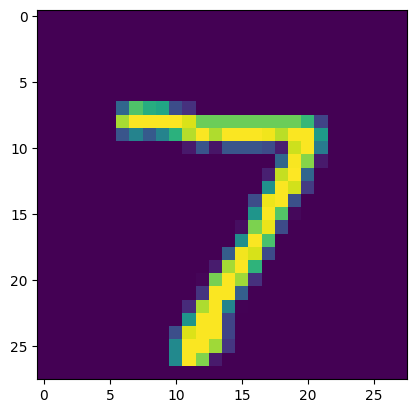

In [48]:
show_image(x, idx=0)

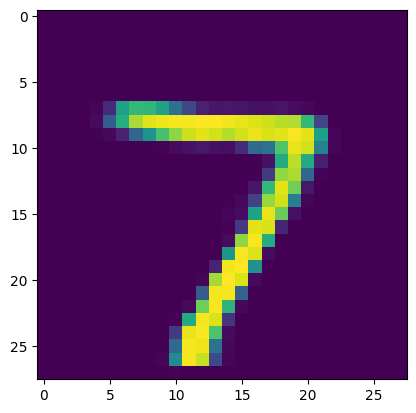

In [49]:
show_image(x_hat, idx=0)

In [50]:
# Generate new images from noise

with torch.no_grad():

    noise = torch.rand(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

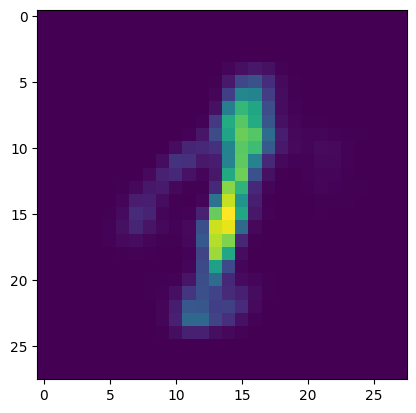

In [52]:
show_image(generated_images, idx=0)